<a href="https://colab.research.google.com/github/Sammm21/ML/blob/main/Pet_Breeds_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastbook import *

     |████████████████████████████████| 727kB 7.4MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 204kB 48.7MB/s 
     |████████████████████████████████| 1.2MB 32.7MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
Mounted at /content/gdrive


In [ ]:
from fastai.vision.all import *
import torch
path = untar_data(URLs.PETS)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [ ]:
(path/"images").ls()

(#7393) [Path('images/Birman_88.jpg'),Path('images/pomeranian_81.jpg'),Path('images/Maine_Coon_54.jpg'),Path('images/saint_bernard_47.jpg'),Path('images/german_shorthaired_180.jpg'),Path('images/beagle_53.jpg'),Path('images/japanese_chin_86.jpg'),Path('images/saint_bernard_138.jpg'),Path('images/wheaten_terrier_167.jpg'),Path('images/japanese_chin_115.jpg')...]

The first thing that we see is the number of items in the collection ´L´ (´L´ can be thought of as an enhanced verion of the ordinary Python ´list´). The first thing that's shown is the number of items in the collection, prefixed with a ´#´.

We can see that the filenames seems to be structured in that they contain the name of a pet breed and then an underscore _ followed by a number, and finally the file extension. 

In [ ]:
fname = (path/"images").ls()[0]
fname

Path('images/Birman_88.jpg')

We are going to want to extract the file names and create labels for our classifier. A very powerful and flexible way to extract informmation from strings is to use pythons *regular expressions* aka *regex*. 

This regular expression picks all the characters leading up to the underscore, as long as the subsequent characters following the underscore are digits followed by the .jpg extension. 

In [ ]:
re.findall(r'(.+)_\d+\.jpg$', fname.name)

['Birman']

We're gonna use the above regular expression to get our labels in our ´DataBlock´ below, for labeling with regular expressions we use the ´RegexLabeller´ class:

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files, 
                 splitter = RandomSplitter(seed = 42),
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms = Resize(460),
                 batch_tfms = aug_transforms(size = 224, min_scale = 0.75))
dls = pets.dataloaders(path/"images")

The following lines in the ´DataBlock´ implement fastais data augmentation technique known as presizing

```
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```



## Presizing

For all image classification tasks we need our images to have the same dimensions, so that they can collate into tensors to be passed to the GPU. We also want to minimize the number of distint augmentations computations we perform. 

The performance requirements suggests that we should, where possible, compose the augmentation transformations into as few transformations as possible (to reduce the number of lossy operations) and transform the images into uniform sizes (for more efficient processing on the GPU).

Presizing achieves this by:
1. Resizing the images to relatively "large" dimensions- that is, dimensions that are significantly larger than the target training dimensions.
2. Compose all the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than perfomring the operations individually and interpolating multiple times. 

The first step creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empy zones. This works by resizing to a square, using a large crop size. On the training set, the crop are is chosen rendomly, and the size of the crop is selected to cover the netire width or height of the image.

In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done togvether, with a single interpolation at the end. 

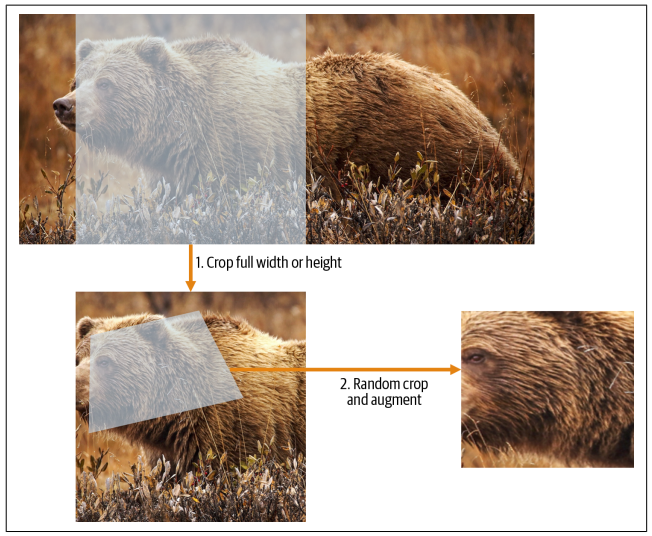

This picture shows the two steps:
1. Crop full width or height: This is in item_tfms, so it’s applied to each individual
image before it is copied to the GPU. It’s used to ensure all images are the same
size. On the training set, the crop area is chosen randomly. On the validation set,
the center square of the image is always chosen.
2. Random crop and augment: This is in batch_tfms, so it’s applied to a batch all at
once on the GPU, which means it’s fast. On the validation set, only the resize to
the final size needed for the model is done here. On the training set, the random
crop and any other augmentations are done first.

To implement this in fastai we yse ´Resize´ as an item trasnform with a large size, and ´RandomResizedCrop´ as a batch transform with a smaller size. ´RandomResizedCrop´ will be added automatically if we include the ´min_scale´ parameter in the ´aug_transform´ function, as is done in the ´DataBlock´ call above. We can also use ´pad´ or ´squish´ instead of ´crop´'(default) for the initial ´Resize´.

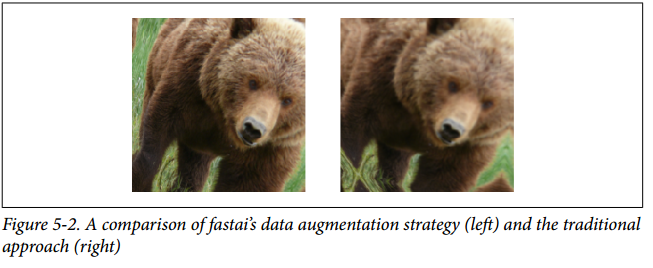

## **Checking and Debuggin a DataBlock**

Writing a `DataBlock` is just like writing a blueprint. We will get an error message if we have syntax errors in the code, but we still have no guarantee that the blueprint is going to work on our data source as we intend. Therefore, before training our model we should always check our data. We can do this using the `show_batch` method:

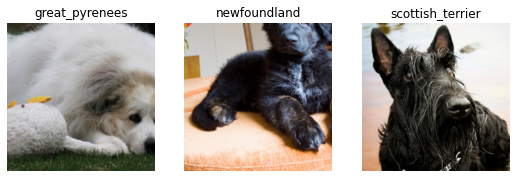

In [ ]:
dls.show_batch(nrows=1, ncols=3)

We can visually inspect each image and see if the labeling seems correct.

The next step to figure out if our `DataBlock` is legit is to use the `summary` method. It will attempt to create a batch from the source we give it, with a lot of details. If it fails we will see exactly at which point the failure happened so that we can go back and debugg it at that step. If we for instance forget to `Resize` our images and thus end up with images of different sizes which will be unabled to be batched (since all images in a batch must be the same size) this is what the `summary` of that bug would look like: 

In [ ]:
pets_debugg_ex = DataBlock(blocks = (ImageBlock, CategoryBlock),
                           get_items = get_image_files,
                           splitter = RandomSplitter(seed = 42),
                           get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets_debugg_ex.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_143.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=332x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_143.jpg
    applying partial gives
      Maine_Coon
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=332x500, TensorCategory(6))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item

RuntimeError: ignored



```
Setting-up type transforms pipelines
Collecting items from /root/.fastai/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_180.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=424x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_180.jpg
    applying partial gives
      scottish_terrier
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(32)

Final sample: (PILImage mode=RGB size=424x500, TensorCategory(32))


Collecting items from /root/.fastai/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=424x500, TensorCategory(32))
    applying ToTensor gives
      (TensorImage of size 3x500x424, TensorCategory(32))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch
Error! It's not possible to collate your items in a batch
Could not collate the 0-th members of your tuples because got the following shapes
torch.Size([3, 500, 424]),torch.Size([3, 500, 376]),torch.Size([3, 500, 396]),torch.Size([3, 500, 338])
```



We can see above exactly how fastai gathers the data and splits it, how it goes from a filename to a sample `(Final sample: (PILImage mode=RGB size=424x500, TensorCategory(32))`, then what item transforms were applied `(Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=424x500, TensorCategory(32))
    applying ToTensor gives
      (TensorImage of size 3x500x424, TensorCategory(32))` and finally how it failed to collate those samples in a batch (because of the different shapes) `Could not collate the 0-th members of your tuples because got the following shapes
torch.Size([3, 500, 424]),torch.Size([3, 500, 376]),torch.Size([3, 500, 396]),torch.Size([3, 500, 338])`

Once we think the data looks right we will want to model it as soon as possible and then use the first model as a tool for further data cleaning and preprocessing:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.494864,0.330989,0.117050,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.525117,0.307169,0.105548,01:10
1,0.343890,0.225578,0.071042,01:10


Check to see what loss fastai has choosen: 

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Plot confusion matrix to see how our preliminary model is doing:

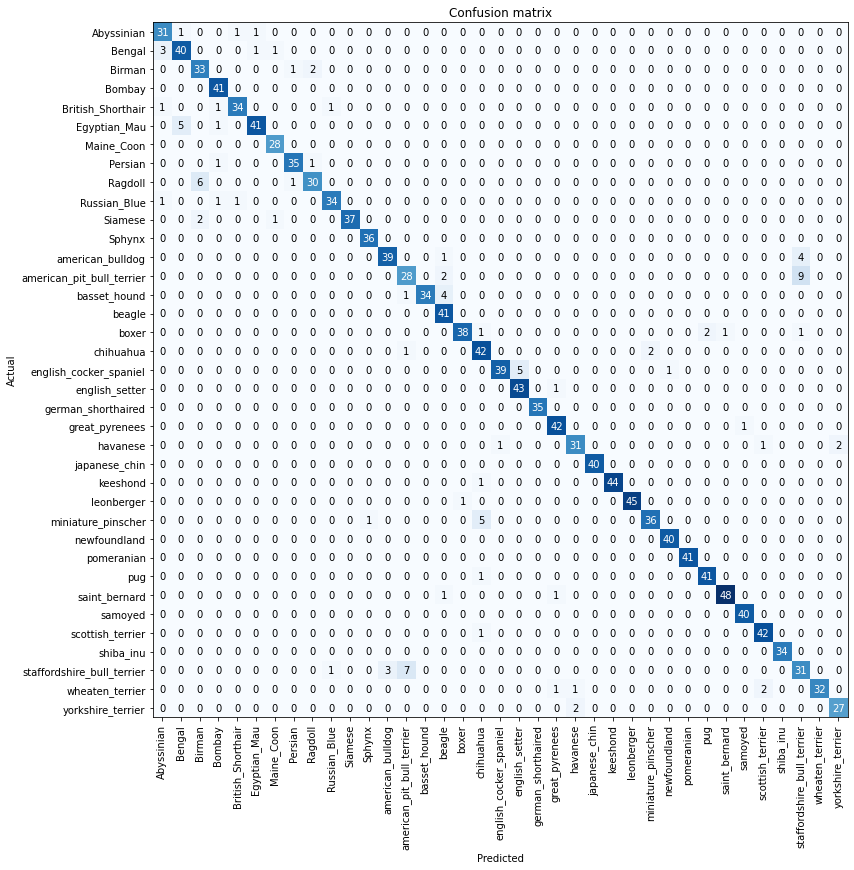

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12))

Seems to be doing pretty good except having some trouble with the AMSTAFF classifications, this confusion matrix is quite large though, a better approach would be to use the the `most_confused()` method in cases like these:


In [ ]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('Ragdoll', 'Birman', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('english_cocker_spaniel', 'english_setter', 5),
 ('miniature_pinscher', 'chihuahua', 5)]

Check out the top losses and what they look like:

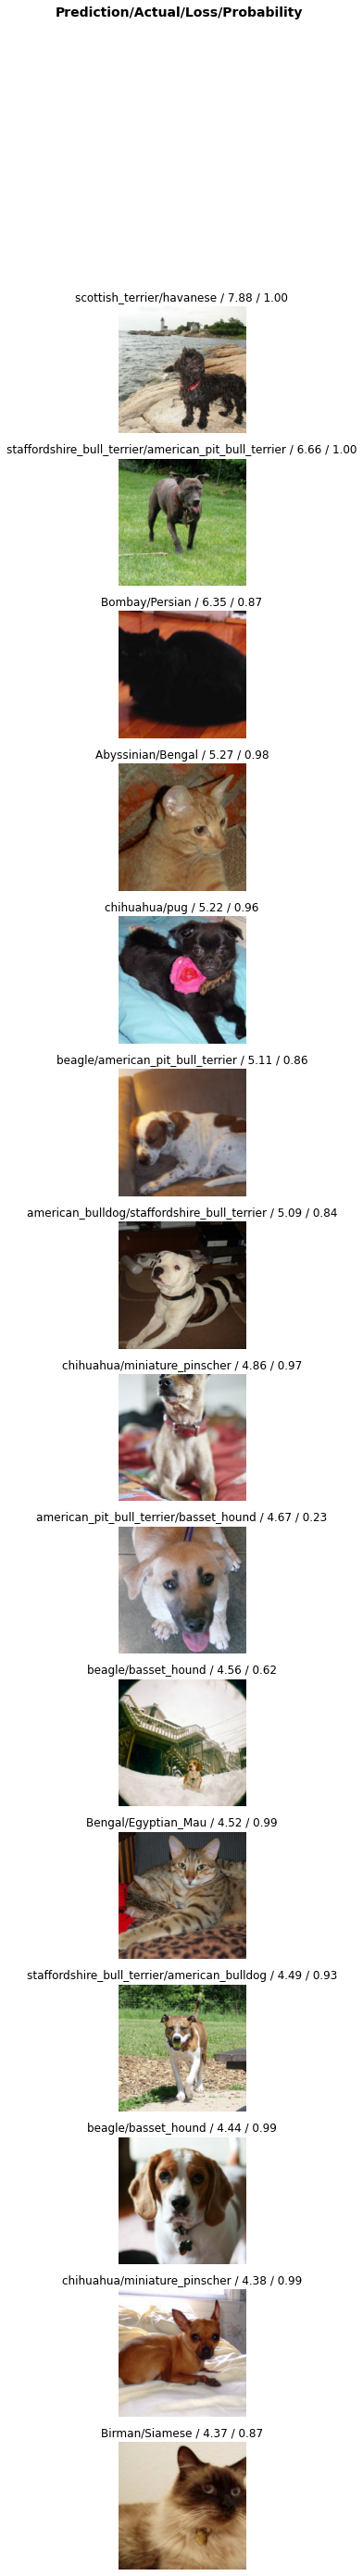

In [ ]:
interp.plot_top_losses(15, nrows=15)

In [ ]:
from fastai.vision.widgets import *

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

## **Cross-Entropy Loss**


*Cross-entropy loss* is a loss function that is similar to mnist loss we created used for binary classification, however it has some benefits:

- It works even when our dependent variable has more than 2 categories
- It reuslts in faster and more reliable training (how and why?) 

**Viewing Activations and Labels**

Let's take a look at the activations of our model. We can get a batch of ral data from our `DataLoaders`, by using the `one_batch` method:

In [ ]:
x, y = dls.one_batch()
# first.dls.train

View the names of the data:

In [ ]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

Print the dependent variable:

In [ ]:
y

TensorCategory([10,  2,  1,  9, 36, 25, 10, 23, 21,  8, 20, 10, 28, 21,  0, 14, 15, 10, 35, 14,  3, 12, 22, 29, 15, 29, 23,  4,  7, 32, 19, 27,  6, 18, 18, 35, 18, 30, 29, 18, 19, 12, 10, 11, 15, 34, 27, 15,
        22, 19, 32, 14,  8, 30, 12, 16,  8, 30, 18, 17, 33,  1, 12, 32], device='cuda:0')

To view the predictions i.e. the activations of the final layer of the neural network we can use `Learner.get_preds`. This function either takes a dataset index as below (0 for train and 1 for valid) or an iterator of batches. Therefore we can pass a simple list with our batch to get predictions. It will return predictions and targets by default, but since we already have the targets, we can ignore them by assigning those to the special variable `_`:

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([5.1897e-04, 7.7429e-05, 1.3789e-03, 1.3160e-01, 1.0917e-03, 1.1580e-05, 4.1162e-06, 4.8707e-05, 5.0112e-04, 1.3803e-03, 8.5615e-01, 8.7075e-06, 1.5978e-05, 8.7604e-05, 9.2108e-05, 7.0408e-05,
        1.6480e-04, 1.3603e-04, 4.8928e-05, 1.0868e-05, 1.8180e-04, 2.4740e-05, 9.0170e-06, 1.6535e-05, 1.6024e-04, 2.2608e-04, 2.0488e-03, 4.0856e-04, 2.1807e-05, 8.4962e-04, 1.6818e-04, 4.6587e-05,
        1.2941e-04, 2.0620e-04, 1.5725e-03, 4.2604e-04, 9.6090e-05])

The actual prediction are 37 probabilities between 0 and 1, which add up to 1 in total:

In [ ]:
len(preds[0]), preds[0].sum()

(37, tensor(1.0000))

To transform the activations in our model into probabilities like this, we use the softmax activation function:

## **Softmax**

We use the Softmax activation function in the final layer for multi-class classification taks to ensure that all the activations ad between 0 and 1, and that they all sum to 1.

Softmax is similar to the sigmoid function:

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


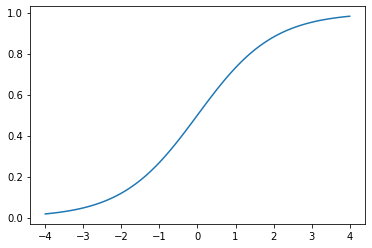

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

We can apply this function to a single column of activations from our neural network and get back a column of numbers between 0 and 1.

What happens if we want to have more categories in our target such as 37 pet breeds? We will need more activations than just a single column: we are going to need an activation per category/breed. If we start by creating a neural net that just predicts 3s or 7s like in the last notebook, we can use that as a spring board to a more general approach with 37 categories. 

Let's create a tensor with some random numbers with a std of 2 (why we multiply `randn` by 2) so in this example we have 6 images (the rows) and 2 possible categories (the columns) representing 3's and 7's:

In [ ]:
torch.random.manual_seed(42)

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We can't just take the sigmoid directly since we don't get the rows to add to 1:

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
# All rows first column - All rows second column
diff = acts[:,0] - acts[:,1]
diff

tensor([ 0.4158,  0.0083, -1.8731,  5.6924,  0.3886, -0.5489])

However, if first we take the differences between the two activation columns, we can then take the sigmoid of those differences which will represent a probability for the first column. 

*Why? Well for our binary classification example our neural network will create a single activation per image, which in this case represents the models confidence that the input was a 3 (3 was coded as 1 and 7 as 0) So in the binary case a single pair of activations simply indicate the relative confidence of the input being (in this case) a 3 vs a 7. Thus taking the difference between the neural net activations will reflect how much more sure the network is that the input is a 3 vs a 7, and then pass that to the sigmoid to turn it into a probability*

Therefore, If we then take 1 - the sigmoid of the differences we will get the probability for the second column. I.e. differences of the sigmoid will give us the probability that predicted class is a 3 and 1 - the sigmoid of the differences will give us the probability that the predicted class is a 7.

In [ ]:
diff.sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

Second column (which is the probability of it being a 7) will be that subtracted from one, since the first column is the probability of it being a 3:

In [ ]:
torch.stack([diff.sigmoid(), 1-diff.sigmoid()], dim=1)

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

The sigmoid works great for binary classification but for multinominal classification we need to be able to do this but for more that two columns. This is were the ´softmax´ function comes into play:



```
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```



The exponential function increases exponentially therefore its great to use to highlight small differences

In [ ]:
math.exp(2.), math.exp(4.)

(7.38905609893065, 54.598150033144236)

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

`softmax` is the multi-category equivalent of `sigmoid`. 

So the softmax is the exponential of the output divided by the sum of the exponentials of all the outputs and that will sum to 1.

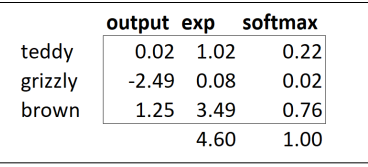

Taking the exponential ensures all our numbers are positive, and then dividing by the sum ensures we are going to have a bunch of numbers that add up to 1. The exponential also has a nice property: if one of the numbers in our activations x is slightly bigger than the others, the exponential will amplify this (since it grows, well... exponentially), which means that in the softmax, that number will be closer to 1.

Intuitively, the softmax function really wants to pick one class among the others, so it's ideal for training a classifier when we know each picture has a definite label. (Note that it may be less ideal during inference i.e. using a model to get predictions rather than training, as we might want your model to tell us if it doesn't recognize any of the classes that it has seen during training, and not pick a class just because it has a slightly bigger activation score. In this case, it might be better to train a model using multiple binary output columns (dummy coding), each using a sigmoid activation.)



Softmax is the first part of the cross-entropy loss—the second part is log likelihood:

## **Log Likelihood**

When we calculated the loss for the MNIST example in the 3s and 7s notebook we used:



```
def mnist_loss(inputs, targets):
  inputs = inputs.sigmoid()
  return torch.where(targets==1, 1-inputs, inputs).mean()

```



In the binary case, we used torch.where to select between inputs and 1-inputs. When we treat a binary classification as a general classification problem with two categories, it actually becomes even easier, because (as we saw in the previous section) we now have two columns, containing the equivalent of inputs and 1-inputs. So, all we need to do is select from the appropriate column. 

Let's try to implement this in PyTorch. For our synthetic 3s and 7s example, let's say these are our labels:

In [ ]:
targ = tensor([0,1,0,1,1,0])

Softmax activations:

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

For each item of `targ` we select the appropriate column of `sm_acts` using tensor indexing, like so:

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

Produce a DataFrame table to see what exactly is going on with our toy example above::

In [ ]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=['3', '7'])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[idx, targ]
t = df.style.hide_index()
# to have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


Looking at this table, you can see that the final column can be calculated by taking the `targ` and `idx` columns as indices into the two-column matrix containing the `3` and `7` columns. That's what `sm_acts[idx, targ]` is actually doing.

This will also work just as well with more than two columns
we can imagine this by considering what would happen if we added an activation column for every digit (0 through 9), and then `targ` contained a number from 0 to 9. As long as the activation columns sum to 1 (as they will, if we use softmax), then we'll have a loss function that shows how well we're predicting each digit.

We're only picking the loss from the column containing the correct label. We don't need to consider the other columns, because by the definition of softmax, they add up to 1 minus the activation corresponding to the correct label. Therefore, making the activation for the correct label as high as possible must mean we're also decreasing the activations of the remaining columns.



In [ ]:
df
t

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


PyTorch provides a function that does exactly the same thing as `sm_acts[range(n), targ]` (except it takes the negative, because when applying the log afterward, we will have negative numbers), called `nll_loss` (*NLL* stands for *negative log likelihood*):

In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

Note: Despite it's name this function does not take the log, that's done in the crossentropy step instead due to computational reasons. 

## **Taking the Log**

When using probabillities as a loss function we have somewhat of a problem in that the cannot be smaller than 0 or greater than 1. That means that our model won't care whether it predicts 0.99 or 0.999, as these numbers are very close to each other, however 0.999 is 10 ties more confident than 0.99 so we want to preserve this distinction and information. We can do this by transforming our numbers to instead of being between 0 and 1 be between negative infinity and 0. That is what the logarithm does. 


As we can se if our input is 0 this will correspond to the tip of the log curve which is infinity and as the input gets close to one the output will be closer and closer to 0 but only reach 0 when it's 1, therefore the differences between 0.9, 0.99, 0.999, 0.9999, 0.99999 and so own will be more appharant:

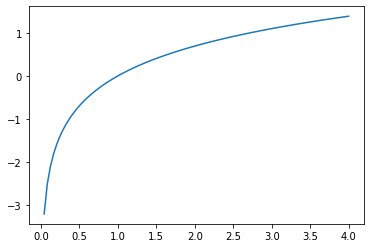

In [ ]:
plot_function(torch.log, min=0, max=4)

The logarithm function has this identity:

```
y = b**a
a = log(y,b)
In this case, we're assuming that log(y,b) returns log y base b. However, PyTorch actually doesn't define log this way: log in Python uses the special number e (2.718...) as the base.
```

The key thing to know about logarithms is this relationship:

`log(a*b) = log(a)+log(b)`


This means that logarithms increase linearly when the underlying signal increases exponentially or multiplicatively. This is used, for instance, in the Richter scale of earthquake severity, and the dB scale of noise levels. It's also often used on financial charts, where we want to show compound growth rates more clearly. 

Logarithms are awesome because it means that multiplication, which can create really really large and really really small numbers, can be replaced by addition, which is much less likely to result in scales that are difficult for our computers to handle.

Taking the mean of the positive or negative log of our probabilities (depending on whether it's the correct or incorrect class) gives us the *negative log likelihood* loss. In PyTorch, `nll_loss` assumes that you already took the log of the softmax, so it doesn't actually do the logarithm for you.

**warning: Confusing Name, Beware: The nll in nll_loss stands for "negative log likelihood," but it doesn't actually take the log at all! It assumes you have already taken the log. PyTorch has a function called log_softmax that combines log and softmax in a fast and accurate way. nll_loss is designed to be used after log_softmax.**

When we first take the softmax, and then the log likelihood of that, that combination is called *cross-entropy loss*. In PyTorch, this is available as `nn.CrossEntropyLoss` (which, in practice, actually does `log_softmax` and then `nll_loss`):

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

All PyTorch function are provided in two forms, the class in the `nn` form and also a plain functioncal form:

(Both forms work fine by class is used by convention)

In [ ]:
F.cross_entropy(acts, targ)

tensor(1.8045)

By default PyTorch loss functions take the mean of the loss of all items. We can use `reduction='none'` to disable that:

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

Note from S: An interesting feature about cross-entropy loss appears when we consider its gradient. The gradient of `cross_entropy(predictions,targets)` is just `softmax(predictions)-targets`. Since `softmax(predictions)` is just the final activation of the model, that means that the gradient is proportional to the difference between the prediction and the target. This is the same as mean squared error in regression (assuming there's no final activation function such as that added by `y_range`), since the gradient of `(predictions-targets)**2` is `2*(predictions-targets)`. Because the gradient is linear, that means we won't see sudden jumps or exponential increases in gradients, which should lead to smoother training of models.

## **Improving our Model**

### **Learning Rate Finder**

The first thing we need to set when training a model is the learning rate. A very low learning rate not only makes the training take a very long time but may also lead to a risk of overfitting the data since every time a complete pass of the data is done, we give our model a chance to memorize it.

What happens if we use a large learning rate?:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3, base_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,69.809998,521.840393,0.980379,01:06


epoch,train_loss,valid_loss,error_rate,time
0,33.690388,737.378723,0.969553,01:10
1,16.005732,5147598.000000,0.970907,01:10
2,7.285274,359395.000000,0.958051,01:10


This doesn't look good the optimizer stepped in the correct direction, but it stepped too far so that it overshot the minimum loss like in the graph below:

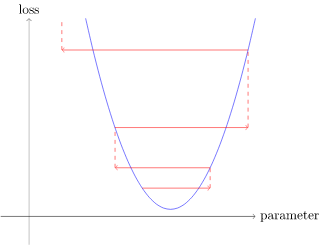

In order to find the perfect learning rate we can use the learning rate finder. The idea is to start with a very, very small lr, use that for one mini batch, find the losses afterwards, and then increase the lr by some percentage (e.g. doubling it each time). Then we do another mini-batch, trakc the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This way we know at what point we've gone to far and we pick an "optimal" learning rate that occures before that point:

- One order of magnitude less than where the minimum loss was achieve (i.e. the minimum divided by 10)
- The last point wheere the loss was clearly decreasing

The learning rate finder in dastai computes those points on a curve to help us:

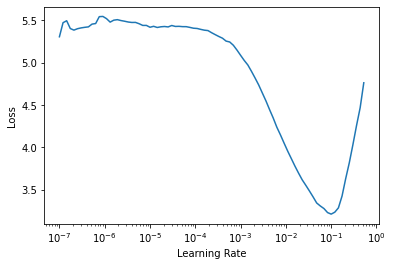

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

*The plot has a logarithmic scale, which is why the middle point between 0.001 and 0.01 is between 0.003 and 0.004. This is because we care mostly about the order of magnitude of the learning rate.* 


A logarithmic scale (or log scale) is a way of displaying numerical data over a very wide range of values in a compact way—typically the largest numbers in the data are hundreds or even thousands of times larger than the smallest numbers. Such a scale is nonlinear: the numbers 10 and 20, and 60 and 70, are not the same distance apart on a log scale. Rather, the numbers 10 and 100, and 60 and 600 are equally spaced. Thus moving a unit of distance along the scale means the number has been multiplied by 10 (or some other fixed factor). Often exponential growth curves are displayed on a log scale, otherwise they would increase too quickly to fit within a small graph. Another way to think about it is that the number of digits of the data grows at a constant rate. For example, the numbers 10, 100, 1000, and 10000 are equally spaced on a log scale, because their numbers of digits is going up by 1 each time: 2, 3, 4, and 5 digits.

**Note: The above graph is a rate, what we want is to pick a learning rate where the gradient is the steepest as that indicates a point were the loss is deacreasing. So you don't want the minimum point of the graph above since at that point the gradient is 0 and the loss isn't decreasing but plateauing. That's why a good learning rate is to take the point of the minimum loss and divide that by 10.** 

In [ ]:
lr_min

0.010000000149011612

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 5.25e-03


A learning rate around 3e-03 seems to be appropriate so let's try that:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.291328,0.339872,0.111637,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.576580,0.368258,0.116373,01:11
1,0.343759,0.255892,0.087280,01:10


## **Unfreezing and Transfer Learning**

When using transfer learning we don't want to mess up the finely tuned layers of the transfer model and instead want to focus on updating and tuning the weights in the later new layers that are specific to our learning problem. In order to achieve this we freeze the pretrained layers of the network.

When we call `fine_tune` method fastai does 2 things:
- Trains the randomly added layers for one epoch, with all other layers frozen
- Unfreezes all of the layers, and trains them all for a the number of epochs requested.

In [ ]:
learn.fine_tune??

Let's recreate this manually with `fit_one_cycle`, which will start training at a low learning rate, gradually increase it for the first section of training, and then gradually decrease it again for the last section of training: 

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.155443,0.326958,0.098782,01:06
1,0.512479,0.249125,0.077808,01:07
2,0.312730,0.225025,0.071719,01:07


Then unfreeze the model:

In [ ]:
learn.unfreeze()

and run `lr_find` again, since we have more layers to train, and weights that have already been trained for 3 epochs, means that the previously found learning rate is no longer optimal or appropriate:

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=1.9054607491852948e-06)

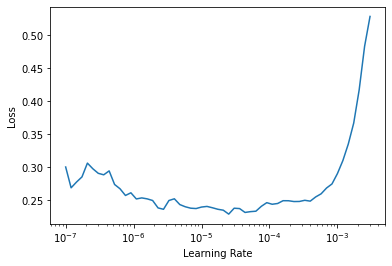

In [ ]:
learn.lr_find()

Note: The graph is different from when the weights were random which makes sense since our model has been trained already so it won't have a sharp decrease in the loss however as we increase the learning rate there will be a point were it gets too big and the loss will get worse which can be seen in the sharp increase of the loss. We will want to take a point well before that sharp increase for the value of the new learning rate. So unlike when we were using random weights we are ignoring the point of the maximum gradient in this iteration. 

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.257225,0.219099,0.063599,01:11
1,0.245478,0.209150,0.066306,01:11
2,0.219318,0.208057,0.063599,01:11
3,0.216447,0.208999,0.064953,01:11
4,0.190690,0.208069,0.067659,01:11
5,0.173789,0.205827,0.060893,01:10


Our model has improved, but the deepest layers of the pretraied model still may not need as high a learning rate as the last layers, so we should probably use different learning rates for the different layers.

## **Discriminative Learning Rates**

Even if we use freeze when we unfreeze and train the entire network with the same learning rate we may mess up the pretrained layers since they usually pick up very basic features like diagonal lines and edges that are pretty general for most image classification task so we don't want to mess those up. Also pretrained weights have been trained often on millions of examples and for many epoch.

This is were dismcriminitive learning comes into play. The idea is very simple we use a much smaller learning rate for the earlier layers and a larger one for the later layers. 

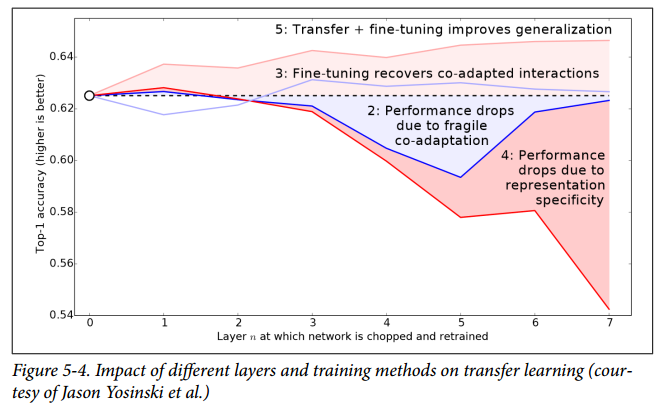

fastai lets you pass a Python `slice` object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range.

So here first we train the model frozen so all the pretrained layers are not trained for 3 epochs. Then we unfreeze the model and train it for 12 epochs with discriminative learning rates for the pretrained layers vs the later layers.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.129308,0.330506,0.102842,01:06
1,0.511775,0.256823,0.088633,01:06
2,0.325895,0.247551,0.083221,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.268404,0.231259,0.079161,01:11
1,0.240430,0.239467,0.075778,01:11
2,0.231098,0.244889,0.077808,01:11
3,0.198203,0.228284,0.071042,01:11
4,0.168836,0.226622,0.071042,01:11
5,0.128504,0.221312,0.066306,01:11
6,0.121803,0.217504,0.066306,01:11
7,0.094027,0.220284,0.069012,01:11
8,0.078273,0.214770,0.071719,01:11
9,0.072323,0.207350,0.066306,01:11


Plot graph of validation and training loss:


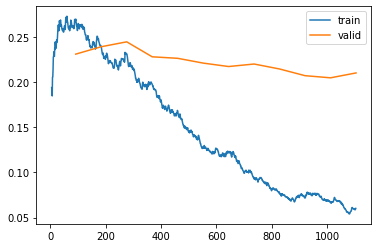

In [ ]:
learn.recorder.plot_loss()

## **Selecting Number of Epochs**


At a certain point the validation loss stops decreasing and levels out while the training loss keeps decreasing, this is the point were the model starts to overfit the data.

## **Deeper Architectures**

In general, a model with more parameters can model your data more accurately. (There are lots and lots of caveats to this generalization, and it depends on the specifics of the architectures you are using, but it is a reasonable rule of thumb for now.)

One way to save memory is to pass the model to `to_fp16` that turns the inputs and outputs to half-floats so 16byte instead of the usual 32 bytes. This can speed up the computations and help avoid memory errors.

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

## **Conclusion**